<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/cv-VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split
from tqdm import tqdm

In [2]:
# Download training data from open datasets.
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
)

100%|██████████| 170498071/170498071 [00:01<00:00, 91429764.99it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size*2, num_workers=2, pin_memory=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights='VGG16_Weights.IMAGENET1K_V1')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s]


In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
for param in model.features.parameters():
    param.requires_grad = False

In [22]:
model.classifier[6] = nn.Linear(4096, 10)

In [23]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_losses = []
    for batch in tqdm(dataloader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn.functional.log_softmax(model(X), dim=-1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    return sum(batch_losses)/len(batch_losses)

In [25]:
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
max_epoch = 25

train_loss = []
for epoch in range(max_epoch):
  print(f"Epoch {epoch+1}")
  epoch_loss = train(train_dataloader,model,loss_fn,optimizer)
  print(f"Train loss: {epoch_loss}")
  train_loss.append(epoch_loss)

Epoch 1


100%|██████████| 782/782 [00:58<00:00, 13.36it/s]


Train loss: 1.1452748305200007
Epoch 2


100%|██████████| 782/782 [00:58<00:00, 13.39it/s]


Train loss: 0.9857297977218238
Epoch 3


100%|██████████| 782/782 [00:58<00:00, 13.35it/s]


Train loss: 0.9169135913062278
Epoch 4


100%|██████████| 782/782 [00:58<00:00, 13.39it/s]


Train loss: 0.8848598239290745
Epoch 5


100%|██████████| 782/782 [00:58<00:00, 13.36it/s]


Train loss: 0.8400555548003262
Epoch 6


100%|██████████| 782/782 [00:58<00:00, 13.30it/s]


Train loss: 0.8350210724126957
Epoch 7


100%|██████████| 782/782 [00:58<00:00, 13.35it/s]


Train loss: 0.8053066231253202
Epoch 8


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.7925662591939082
Epoch 9


100%|██████████| 782/782 [00:58<00:00, 13.40it/s]


Train loss: 0.7864425372132255
Epoch 10


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.7671125236222202
Epoch 11


100%|██████████| 782/782 [00:58<00:00, 13.36it/s]


Train loss: 0.7249231764956203
Epoch 12


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.7259217756788444
Epoch 13


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.709256669711274
Epoch 14


100%|██████████| 782/782 [00:58<00:00, 13.38it/s]


Train loss: 0.7102238028631795
Epoch 15


100%|██████████| 782/782 [00:58<00:00, 13.40it/s]


Train loss: 0.7017973303947302
Epoch 16


100%|██████████| 782/782 [00:58<00:00, 13.35it/s]


Train loss: 0.6920929675364433
Epoch 17


100%|██████████| 782/782 [00:58<00:00, 13.38it/s]


Train loss: 0.6654737718651057
Epoch 18


100%|██████████| 782/782 [00:58<00:00, 13.44it/s]


Train loss: 0.6721162260188471
Epoch 19


100%|██████████| 782/782 [00:58<00:00, 13.40it/s]


Train loss: 0.6581776008352904
Epoch 20


100%|██████████| 782/782 [00:58<00:00, 13.38it/s]


Train loss: 0.6356924414024938
Epoch 21


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.6198440943951802
Epoch 22


100%|██████████| 782/782 [00:58<00:00, 13.40it/s]


Train loss: 0.6260907039084398
Epoch 23


100%|██████████| 782/782 [00:58<00:00, 13.38it/s]


Train loss: 0.6162821814379729
Epoch 24


100%|██████████| 782/782 [00:58<00:00, 13.37it/s]


Train loss: 0.6148316431457125
Epoch 25


100%|██████████| 782/782 [00:58<00:00, 13.36it/s]

Train loss: 0.5940743735836594


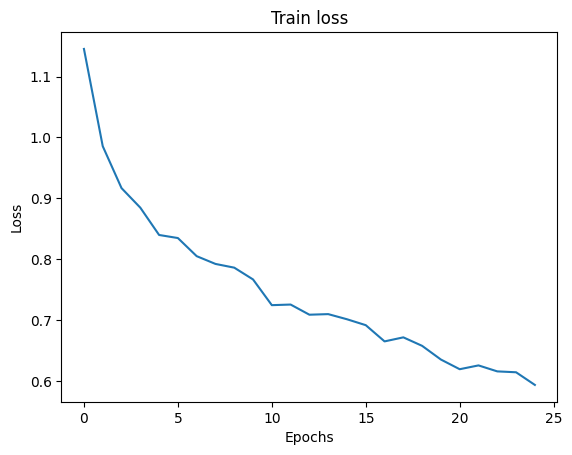

In [28]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [29]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
test(test_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.740038 

